In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from dataclasses import dataclass

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, brier_score_loss
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from scipy.stats import gaussian_kde

import time

for the report:

- no title on plots
- add captions to the plot that are very self explanatory
- add units in the caption (if required)
- if using abbreviations - mention it explicitly
- do not use package name - eg PyMC - mention how YOU implemented the algorithm on your own 
- even when adding tables - should be self-explanatory 
- add grids / axis labels in the plots

## 1 Load Data

In [4]:
data_dir = Path.cwd() / "wdbc.data"
data_dir

PosixPath('/Users/AnanyaPal1/Documents/TUD/5th semester/monte carlo simulations/bayesian-classification-with-mcmc/wdbc.data')

In [5]:
# Path to your local file
DATA_PATH = Path("data/wdbc.data")

# Column names (no header in file)
feature_groups = ["mean", "se", "worst"]
feature_names_base = [
    "radius", "texture", "perimeter", "area", "smoothness", "compactness",
    "concavity", "concave_points", "symmetry", "fractal_dimension"
]
feature_names = []
for grp in feature_groups:
    for base in feature_names_base:
        feature_names.append(f"{grp}_{base}")

cols = ["id", "diagnosis"] + feature_names

df = pd.read_csv(DATA_PATH, header=None, names=cols)

df.head()


,id,diagnosis,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## 2 Descriptive Statistics

In [6]:
print("Shape:", df.shape)
print("\nClass counts:\n", df["diagnosis"].value_counts())
print("\nMissing values:\n", df.isna().sum().sum())

# Basic numeric summary
df.describe().T.head(10)

Shape: (569, 32)

Class counts:
 diagnosis
B    357
M    212
Name: count, dtype: int64

Missing values:
 0


,count,mean,std,min,25%,50%,75%,max
id,569.0,3.037183e+07,1.250206e+08,8670.00000,869218.00000,906024.00000,8.813129e+06,9.113205e+08
mean_radius,569.0,1.412729e+01,3.524049e+00,6.98100,11.70000,13.37000,1.578000e+01,2.811000e+01
mean_texture,569.0,1.928965e+01,4.301036e+00,9.71000,16.17000,18.84000,2.180000e+01,3.928000e+01
mean_perimeter,569.0,9.196903e+01,2.429898e+01,43.79000,75.17000,86.24000,1.041000e+02,1.885000e+02
mean_area,569.0,6.548891e+02,3.519141e+02,143.50000,420.30000,551.10000,7.827000e+02,2.501000e+03
mean_smoothness,569.0,9.636028e-02,1.406413e-02,0.05263,0.08637,0.09587,1.053000e-01,1.634000e-01
mean_compactness,569.0,1.043410e-01,5.281276e-02,0.01938,0.06492,0.09263,1.304000e-01,3.454000e-01
mean_concavity,569.0,8.879932e-02,7.971981e-02,0.00000,0.02956,0.06154,1.307000e-01,4.268000e-01
mean_concave_points,569.0,4.891915e-02,3.880284e-02,0.00000,0.02031,0.03350,7.400000e-02,2.012000e-01
mean_symmetry,569.0,1.811619e-01,2.741428e-02,0.10600,0.16190,0.17920,1.957000e-01,3.040000e-01


### 2.1 Class Balance Plot

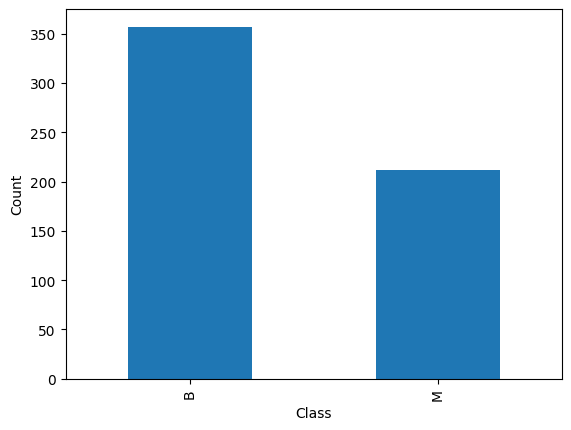

In [51]:
ax = df["diagnosis"].value_counts().plot(kind="bar")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.show()

The distribution of benign (B) and malignant (M) diagnoses in the WDBC dataset is displayed in this plot. 
There is a moderate class imbalance in the data, with more benign cases than malignant ones. 
Since imbalance can affect metrics like accuracy and calibration, it is crucial to comprehend this balance when assessing classification performance and interpreting predictive probabilities. 

Prior to applying Bayesian modeling and uncertainty analysis, the visualization offers a preliminary summary of the target variable.

### 2.2 Feature Distributions

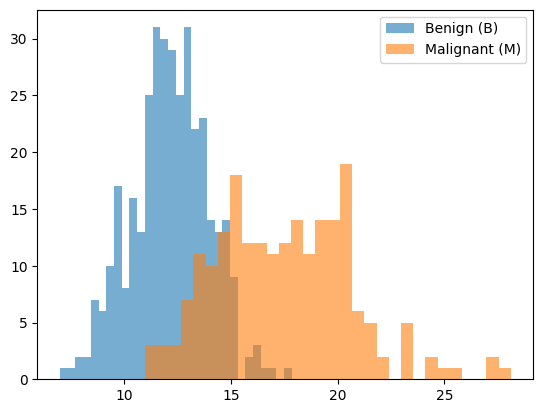

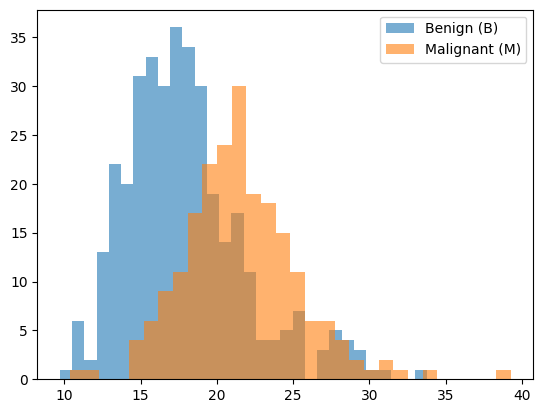

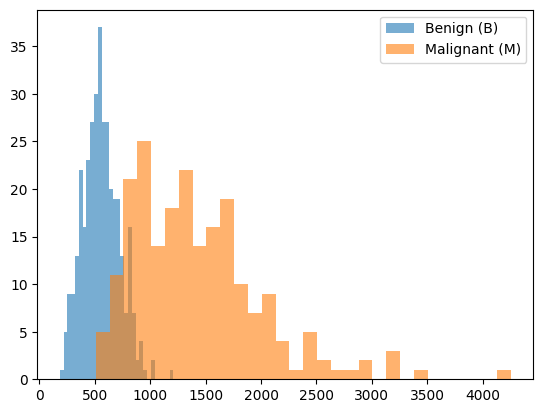

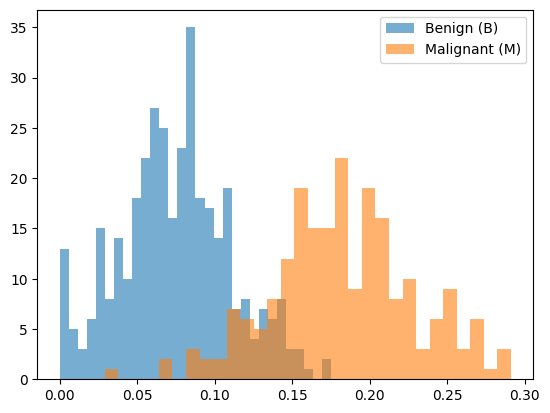

In [52]:
sample_feats = ["mean_radius", "mean_texture", "worst_area", "worst_concave_points"]
df_m = df[df["diagnosis"]=="M"]
df_b = df[df["diagnosis"]=="B"]

for c in sample_feats:
    plt.figure()
    plt.hist(df_b[c], bins=30, alpha=0.6, label="Benign (B)")
    plt.hist(df_m[c], bins=30, alpha=0.6, label="Malignant (M)")
    #plt.title(f"Distribution: {c}")
    plt.legend()
    plt.show()


These histograms contrast the distributions of particular features in benign and malignant cases. 
Numerous variables exhibit distinct changes in location and distribution between the two classes, indicating the presence of potent discriminative signals in tumor morphology. The use of probabilistic classification models that can learn feature effects while taking uncertainty into account is encouraged by the apparent separation.

## 3 Preprocessing

### 3.1 Encode labels and train/test split

In [9]:
# Encode: M=1, B=0
y = (df["diagnosis"] == "M").astype(int).to_numpy()
X = df[feature_names].to_numpy(dtype=float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train malignant rate:", y_train.mean(), "Test malignant rate:", y_test.mean())

Train shape: (426, 30) Test shape: (143, 30)
Train malignant rate: 0.3732394366197183 Test malignant rate: 0.3706293706293706


### 3.2 Standardize features and add intercept

In [10]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Add intercept column
X_train_i = np.column_stack([np.ones(X_train_s.shape[0]), X_train_s])
X_test_i  = np.column_stack([np.ones(X_test_s.shape[0]),  X_test_s])

d = X_train_i.shape[1]
print("Design matrix dimension (incl intercept):", d)

Design matrix dimension (incl intercept): 31


## 4. Implement Random Walk Metropolis–Hastings (Bayesian Logistic Regression)

This section implements Bayesian logistic regression using a Random Walk Metropolis–Hastings sampler to draw posterior samples of the model parameters when closed-form inference is not available.

### 4.1 Log-posterior definition

The log-posterior combines information from the data and prior assumptions and is also considered as the target density that the Metropolis–Hastings sampler explores in subsequent steps.

In [11]:
def sigmoid(z):
    z = np.clip(z, -35, 35)
    return 1.0 / (1.0 + np.exp(-z))

def log_likelihood(beta, X, y):
    # Bernoulli-logistic log-likelihood
    z = X @ beta
    p = sigmoid(z)
    eps = 1e-12
    return np.sum(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps))

def log_prior(beta, sigma=5.0):
    # IID Normal(0, sigma^2)
    return -0.5 * np.sum((beta / sigma) ** 2) - len(beta) * np.log(sigma)

def log_posterior(beta, X, y, prior_sigma=5.0):
    return log_likelihood(beta, X, y) + log_prior(beta, sigma=prior_sigma)


### 4.2 MH Sampler (single chain)

Implement a single-chain Random Walk Metropolis–Hastings sampler to generate posterior draws of the logistic regression coefficients. 
- At each iteration, a Gaussian proposal is evaluated using the log-posterior, and accepted or rejected according to the Metropolis rule. 
- An adaptive step-size adjustment during burn-in encourages stable acceptance rates, after which samples are collected to approximate the posterior distribution.

In [12]:
@dataclass
class MHSamples:
    draws: np.ndarray
    acceptance_rate: float
    step_size: float

def metropolis_hastings(
    X, y,
    n_samples=12000,
    burn_in=4000,
    step_size=0.05,
    prior_sigma=5.0,
    seed=0,
    adapt=True
) -> MHSamples:
    rng = np.random.default_rng(seed)
    d = X.shape[1]

    beta = np.zeros(d)
    curr_lp = log_posterior(beta, X, y, prior_sigma=prior_sigma)

    draws = []
    accepted = 0

    for t in range(n_samples):
        prop = beta + rng.normal(0, step_size, size=d)
        prop_lp = log_posterior(prop, X, y, prior_sigma=prior_sigma)

        log_alpha = prop_lp - curr_lp
        if np.log(rng.random()) < log_alpha:
            beta = prop
            curr_lp = prop_lp
            accepted += 1

        # light adaptation during burn-in (target acceptance ~0.25)
        if adapt and t > 0 and t < burn_in and (t % 200 == 0):
            acc_rate = accepted / (t + 1)
            if acc_rate < 0.20:
                step_size *= 0.9
            elif acc_rate > 0.35:
                step_size *= 1.1

        if t >= burn_in:
            draws.append(beta.copy())

    draws = np.asarray(draws)
    return MHSamples(draws=draws, acceptance_rate=accepted / n_samples, step_size=step_size)


### 4.3 Run multiple chains (convergence checks)

Run multiple independent Random Walk Metropolis–Hastings chains to enable convergence diagnostics and posterior reliability checks. 

Using different random seeds helps assess mixing behaviour across chains.

In [60]:
n_chains = 4
chains = []

start = time.perf_counter()

for c in range(n_chains):
    out = metropolis_hastings(
        X_train_i, y_train,
        n_samples=15000,
        burn_in=5000,
        step_size=0.06,
        prior_sigma=5.0,
        seed=123 + c,
        adapt=True
    )
    chains.append(out)
    print(f"Chain {c}: draws={out.draws.shape}, acc={out.acceptance_rate:.3f}, final step={out.step_size:.4f}")

mh_time = time.perf_counter() - start

print(f"\nRW–MH total runtime: {mh_time:.2f} seconds")

Chain 0: draws=(10000, 31), acc=0.165, final step=0.5910
Chain 1: draws=(10000, 31), acc=0.162, final step=0.5910
Chain 2: draws=(10000, 31), acc=0.167, final step=0.5910
Chain 3: draws=(10000, 31), acc=0.179, final step=0.5910

RW–MH total runtime: 1.49 seconds


## 5 Implement Hamiltonian Monte Carlo (HMC)

Implement vanilla HMC with:
- Gaussian momentum
- Leapfrog integrator
- Metropolis correction

### 5.1 Gradient of the Log Posterior

Derive the gradient of the log-posterior for Bayesian logistic regression. 

The gradient combines the contribution from the Bernoulli log-likelihood and the Gaussian prior, 
and guides HMC geometrically to propose efficient moves in parameter space.


In [27]:
def grad_log_posterior(beta, X, y, prior_sigma=5.0):
    """
    Gradient of log posterior for Bayesian logistic regression
    """
    z = X @ beta
    p = sigmoid(z)
    grad_ll = X.T @ (y - p)
    grad_prior = -beta / (prior_sigma**2)
    return grad_ll + grad_prior

### 5.2 Leapfrog Integrator

Numerically approximates Hamiltonian dynamics by alternating updates of the parameter vector and a momentum variable. 

Allows HMC to explore the posterior efficiently while maintaining a valid Metropolis correction step.

In [28]:
def leapfrog(beta, momentum, step_size, n_steps, X, y, prior_sigma):
    """
    Perform leapfrog integration
    """
    p = momentum.copy()
    b = beta.copy()

    # half-step momentum update
    p += 0.5 * step_size * grad_log_posterior(b, X, y, prior_sigma)

    for _ in range(n_steps):
        # full-step position update
        b += step_size * p

        # full-step momentum update (except last)
        grad = grad_log_posterior(b, X, y, prior_sigma)
        p += step_size * grad

    # final half-step correction
    p -= 0.5 * step_size * grad

    # negate momentum for reversibility
    return b, -p


### 5.3 Hamiltonian & HMC Sampler

Each iteration simulates a trajectory using the leapfrog integrator and accepts or rejects the 
proposed state based on energy conservation. 

Compared to random-walk proposals, HMC uses gradient information to reduce autocorrelation and improve exploration of the posterior in regions of high relevance.


In [29]:
def hamiltonian(beta, momentum, X, y, prior_sigma):
    kinetic = 0.5 * np.sum(momentum**2)
    potential = -log_posterior(beta, X, y, prior_sigma)
    return kinetic + potential


In [30]:
@dataclass
class HMCSamples:
    draws: np.ndarray
    acceptance_rate: float
    step_size: float
    n_steps: int
    runtime: float


In [31]:
import time

def hmc_sampler(
    X, y,
    n_samples=8000,
    burn_in=3000,
    step_size=0.01,
    n_steps=25,
    prior_sigma=5.0,
    seed=0
) -> HMCSamples:

    rng = np.random.default_rng(seed)
    d = X.shape[1]

    beta = np.zeros(d)
    draws = []
    accepted = 0

    start = time.time()

    for t in range(n_samples):
        momentum = rng.normal(size=d)

        H_current = hamiltonian(beta, momentum, X, y, prior_sigma)

        beta_prop, momentum_prop = leapfrog(
            beta, momentum, step_size, n_steps, X, y, prior_sigma
        )

        H_prop = hamiltonian(beta_prop, momentum_prop, X, y, prior_sigma)

        log_alpha = H_current - H_prop
        if np.log(rng.random()) < log_alpha:
            beta = beta_prop
            accepted += 1

        if t >= burn_in:
            draws.append(beta.copy())

    runtime = time.time() - start

    return HMCSamples(
        draws=np.asarray(draws),
        acceptance_rate=accepted / n_samples,
        step_size=step_size,
        n_steps=n_steps,
        runtime=runtime
    )


### 5.4 Run HMC (Multiple Chains)

Running several chains with different initial seeds enables diagnostic checks (trace comparisons, calculating effective sample size).

In [61]:
hmc_chains = []

start = time.perf_counter()

for c in range(4):
    out = hmc_sampler(
        X_train_i, y_train,
        n_samples=12000,
        burn_in=4000,
        step_size=0.01,
        n_steps=30,
        prior_sigma=5.0,
        seed=100 + c
    )
    hmc_chains.append(out)
    print(f"HMC chain {c}: draws={out.draws.shape}, "
          f"acc={out.acceptance_rate:.3f}, time={out.runtime:.1f}s")
    

hmc_time = time.perf_counter() - start

print(f"\nHMC total runtime: {hmc_time:.2f} seconds")


HMC chain 0: draws=(8000, 31), acc=1.000, time=6.7s
HMC chain 1: draws=(8000, 31), acc=1.000, time=6.8s
HMC chain 2: draws=(8000, 31), acc=1.000, time=6.9s
HMC chain 3: draws=(8000, 31), acc=1.000, time=7.5s

HMC total runtime: 27.97 seconds


## 6. Convergence Diagnostics — RW-MH

Evaluate the convergence and sampling efficiency of the Random Walk Metropolis–Hastings (RW–MH) sampler. 

### 6.1 Trace plots (RW-MH)

Visualize the sampled parameter values across multiple RW–MH chains. 

Ideal observation: Well-mixed chains should overlap and explore similar regions of the posterior without strong trends or drift.

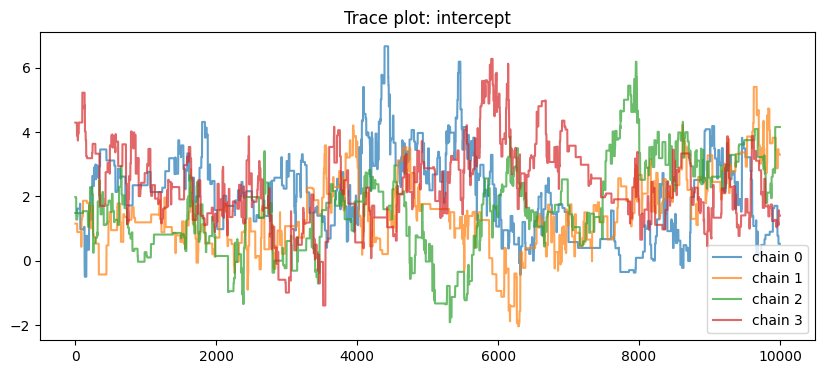

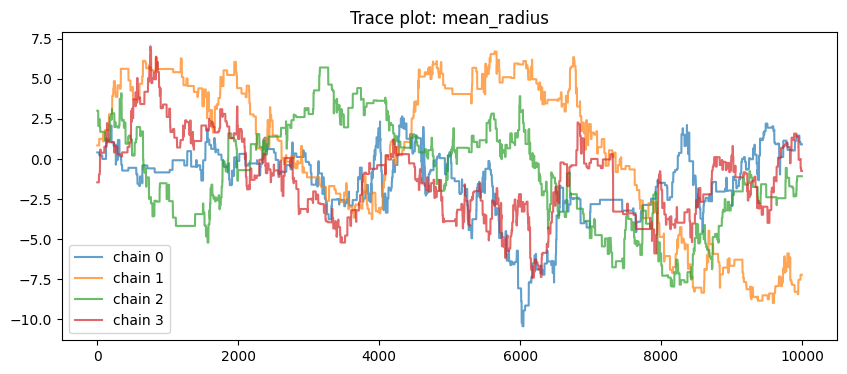

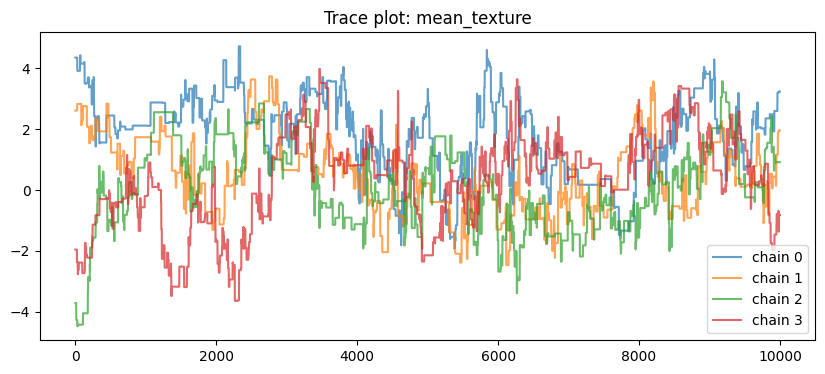

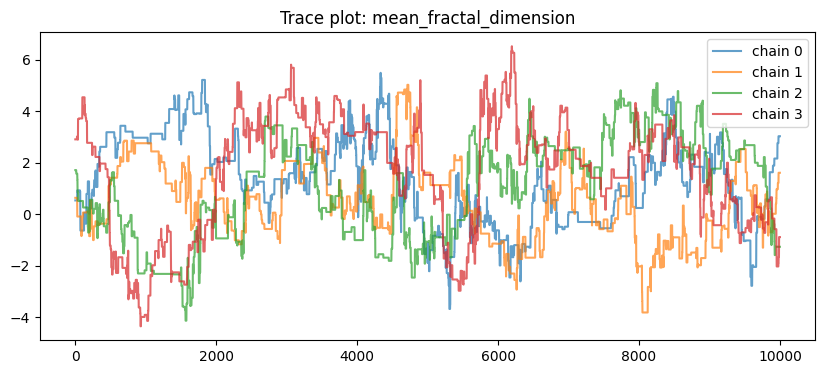

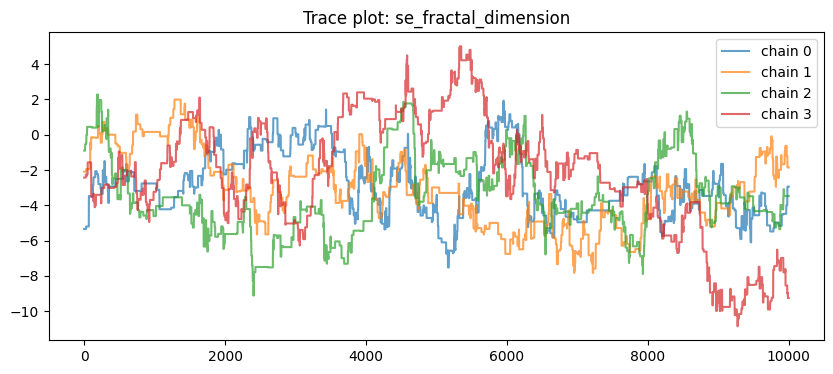

In [14]:
# Pick a few dimensions to inspect: intercept + a few features
dims_to_plot = [0, 1, 2, 10, 20]  # feel free to change
labels = ["intercept"] + feature_names

for dim in dims_to_plot:
    plt.figure(figsize=(10, 4))
    for c, out in enumerate(chains):
        plt.plot(out.draws[:, dim], alpha=0.7, label=f"chain {c}")
    plt.title(f"Trace plot: {labels[dim]}")
    plt.legend()
    plt.show()


The chains explore similar regions but show slow movement and obvious autocorrelation. 
This behavior encourages comparison with gradient-based samplers like HMC and suggests diffusive exploration typical of random-walk proposals.

### 6.2 Autocorrelation and Effective Sample Size (ESS) (RW–MH)

Autocorrelation quantifies dependence between successive samples, while ESS estimates the amount of independent information contained in the chain. 
High autocorrelation reduces sampling efficiency and increases Monte Carlo error.

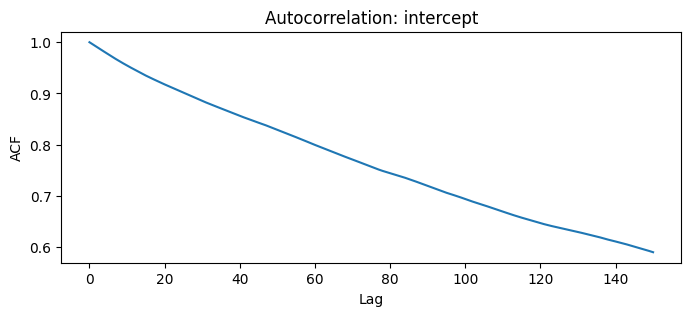

ESS (chain 0) for intercept: 26.3 / 10000


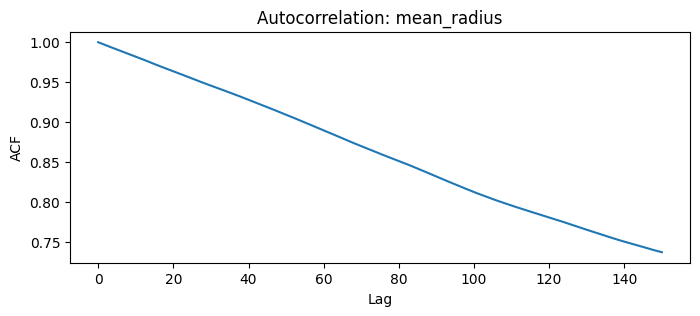

ESS (chain 0) for mean_radius: 21.9 / 10000


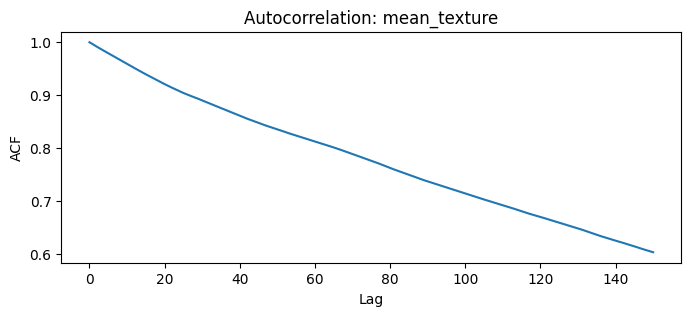

ESS (chain 0) for mean_texture: 26.5 / 10000


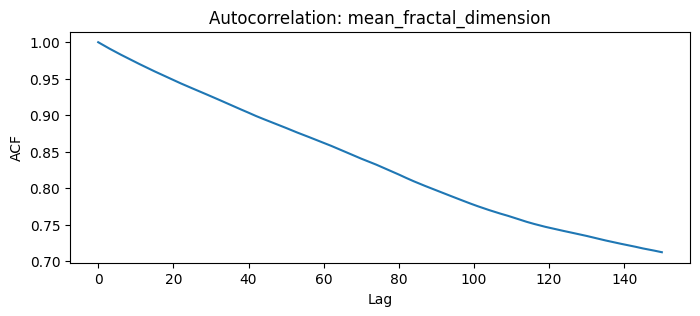

ESS (chain 0) for mean_fractal_dimension: 22.5 / 10000


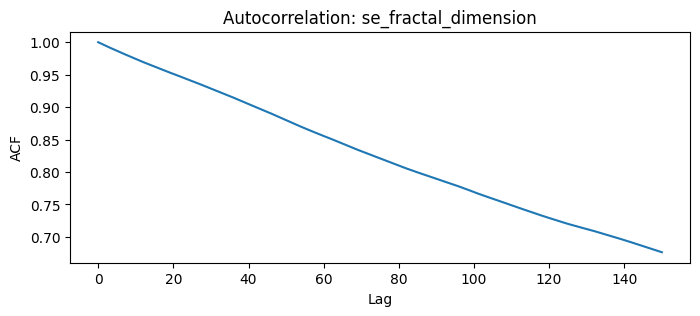

ESS (chain 0) for se_fractal_dimension: 23.9 / 10000


In [15]:
def autocorr_1d(x, max_lag=200):
    x = np.asarray(x)
    x = x - x.mean()
    denom = np.dot(x, x)
    ac = np.empty(max_lag + 1)
    ac[0] = 1.0
    for lag in range(1, max_lag + 1):
        ac[lag] = np.dot(x[:-lag], x[lag:]) / denom
    return ac

def ess_1d(x, max_lag=200):
    ac = autocorr_1d(x, max_lag=max_lag)
    # Geyer's initial positive sequence idea (simple version):
    # sum autocorr until it becomes negative
    s = 0.0
    for k in range(1, len(ac)):
        if ac[k] < 0:
            break
        s += ac[k]
    n = len(x)
    tau = 1 + 2*s
    return n / tau

# Plot autocorr and ESS for one chain on a few dims
chain0 = chains[0].draws
for dim in dims_to_plot:
    ac = autocorr_1d(chain0[:, dim], max_lag=150)
    plt.figure(figsize=(8, 3))
    plt.plot(ac)
    plt.title(f"Autocorrelation: {labels[dim]}")
    plt.xlabel("Lag")
    plt.ylabel("ACF")
    plt.show()

    print(f"ESS (chain 0) for {labels[dim]}: {ess_1d(chain0[:, dim], max_lag=300):.1f} / {len(chain0)}")


Autocorrelation decays very slowly, leading to extremely low ESS values relative to the total number of iterations. 
This confirms that RW–MH mixes inefficiently in this high-dimensional logistic regression setting.

### 6.3 Gelman–Rubin R-hat (RW–MH)

Compares between-chain and within-chain variance to check convergence across multiple RW–MH chains. 
Values close to 1 indicate convergence, whereas larger values suggest poor mixing or insufficient exploration.

In [16]:
def rhat(chains_array):
    """
    chains_array shape: (m_chains, n_draws, d_params)
    """
    m, n, d = chains_array.shape
    chain_means = chains_array.mean(axis=1)            # (m, d)
    chain_vars = chains_array.var(axis=1, ddof=1)      # (m, d)

    W = chain_vars.mean(axis=0)                        # (d,)
    B = n * chain_means.var(axis=0, ddof=1)            # (d,)

    var_hat = ((n - 1) / n) * W + (1 / n) * B
    R = np.sqrt(var_hat / W)
    return R

chains_arr = np.stack([c.draws for c in chains], axis=0)
R = rhat(chains_arr)

# Show worst offenders
worst = np.argsort(-R)[:10]
print("Top 10 R-hat values:")
for j in worst:
    print(f"{labels[j]:<25} R-hat={R[j]:.4f}")


Top 10 R-hat values:
worst_perimeter           R-hat=1.3987
worst_radius              R-hat=1.2933
mean_compactness          R-hat=1.2484
mean_concavity            R-hat=1.2397
mean_area                 R-hat=1.2387
worst_area                R-hat=1.2298
worst_smoothness          R-hat=1.2217
worst_compactness         R-hat=1.2177
mean_smoothness           R-hat=1.2089
mean_concave_points       R-hat=1.1854


A lot of parameters exhibit R-hat values substantially above 1, indicating incomplete convergence and strong dependence on initial conditions. 
This supports previously highlighted limitations of random-walk proposals.

### 6.4 Posterior Summary (RW–MH)

Obtained by pooling all RW–MH chains after burn-in. 

In [17]:
# Combine all chains
all_draws = chains_arr.reshape(-1, d)

post_mean = all_draws.mean(axis=0)
post_ci = np.quantile(all_draws, [0.025, 0.975], axis=0)

summary = pd.DataFrame({
    "param": labels,
    "mean": post_mean,
    "ci2.5": post_ci[0],
    "ci97.5": post_ci[1],
})
summary.sort_values("mean", key=np.abs, ascending=False).head(15)


,param,mean,ci2.5,ci97.5
11,se_radius,7.090187,0.372801,13.049399
8,mean_concave_points,6.902681,-1.496520,12.031585
6,mean_compactness,-6.274379,-13.274868,0.880481
29,worst_symmetry,6.257204,2.980630,11.560042
22,worst_texture,5.981138,2.522536,10.057717
14,se_area,5.501893,-0.367467,15.959281
7,mean_concavity,4.169912,-4.684828,11.820084
23,worst_perimeter,3.776656,-3.909480,11.281929
18,se_concave_points,3.406168,-2.180363,8.723402
27,worst_concavity,3.355425,-1.683558,9.984449


Several coefficients show large magnitudes with wide credible intervals, reflecting uncertainty induced by slow mixing and correlated samples from the RW–MH sampler.

### 6.5 MCSE via Batch Means (RW–MH)

Quantifies simulation uncertainty in posterior estimates. 
Batch means are used to account for autocorrelation in the RW–MH chain.

In [18]:
def mcse_batch_means(x, n_batches=30):
    x = np.asarray(x)
    n = len(x)
    b = n // n_batches
    x = x[:b*n_batches]
    batch_means = x.reshape(n_batches, b).mean(axis=1)
    # variance of batch means / n_batches, then sqrt
    return batch_means.std(ddof=1) / np.sqrt(n_batches)

mcse = np.array([mcse_batch_means(all_draws[:, j], n_batches=30) for j in range(d)])
summary["mcse_mean"] = mcse
summary.head()


,param,mean,ci2.5,ci97.5,mcse_mean
0,intercept,1.869314,-0.591121,4.526921,0.164690
1,mean_radius,-0.794530,-7.684590,5.623041,0.535713
2,mean_texture,0.681808,-2.383582,3.524698,0.200822
3,mean_perimeter,-2.833511,-9.880810,3.296125,0.596764
4,mean_area,1.448183,-5.855110,10.820005,0.692506


Relatively large MCSE values indicate that substantial simulation error remains, consistent with the low ESS observed earlier.

## 7. Posterior Predictive Inference and Uncertainty Quantification - RW–MH

- Evaluate predictive performance and uncertainty using posterior samples from the RW–MH Bayesian logistic regression model. 

- Posterior predictive probabilities are obtained via Monte Carlo integration, enabling credible intervals, entropy-based uncertainty measures, and selective prediction strategies.

### 7.1 Posterior predictive draws

- Computed by averaging logistic predictions across posterior draws.
- Integrates over parameter uncertainty to output calibrated probabilistic predictions.

In [19]:
# posterior predictive probabilities for each test point across posterior draws
# shape: (n_test, n_draws)
p_draws = sigmoid(X_test_i @ all_draws.T)

p_mean = p_draws.mean(axis=1)
p_lo, p_hi = np.quantile(p_draws, [0.025, 0.975], axis=1)

y_pred = (p_mean >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, p_mean)
brier = brier_score_loss(y_test, p_mean)

print("Bayesian Logistic (MH) Accuracy:", acc)
print("Bayesian Logistic (MH) ROC AUC:", auc)
print("Bayesian Logistic (MH) Brier:", brier)
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nReport:\n", classification_report(y_test, y_pred, digits=3))


Bayesian Logistic (MH) Accuracy: 0.972027972027972
Bayesian Logistic (MH) ROC AUC: 0.9914046121593292
Bayesian Logistic (MH) Brier: 0.03146666750564071

Confusion matrix:
 [[89  1]
 [ 3 50]]

Report:
               precision    recall  f1-score   support

           0      0.967     0.989     0.978        90
           1      0.980     0.943     0.962        53

    accuracy                          0.972       143
   macro avg      0.974     0.966     0.970       143
weighted avg      0.972     0.972     0.972       143



The Bayesian RW–MH model achieves high predictive accuracy and strong calibration (low Brier score), meaning that posterior averaging provides robust probabilistic predictions despite poor sampling.

### 7.2 Credible intervals

Credible interval width and mutual information provide a measure of model confidence and parameter uncertainty.


In [20]:
eps = 1e-12

# Total predictive uncertainty (entropy of mean prob)
H_pred = -(p_mean*np.log(p_mean+eps) + (1-p_mean)*np.log(1-p_mean+eps))

# Expected data uncertainty: E[H(Bernoulli(p))]
H_exp = -(p_draws*np.log(p_draws+eps) + (1-p_draws)*np.log(1-p_draws+eps)).mean(axis=1)

# Epistemic uncertainty proxy: mutual information
MI = H_pred - H_exp

ci_width = p_hi - p_lo

uq = pd.DataFrame({
    "y_true": y_test,
    "p_mean": p_mean,
    "p_lo": p_lo,
    "p_hi": p_hi,
    "ci_width": ci_width,
    "H_pred": H_pred,
    "MI": MI
})
uq.sort_values("H_pred", ascending=False).head(10)


,y_true,p_mean,p_lo,p_hi,ci_width,H_pred,MI
92,1,0.586430,0.021274,0.997443,0.976169,0.678132,0.284139
101,0,0.366300,0.000069,0.999846,0.999778,0.656957,0.423761
109,1,0.648316,0.005342,0.999895,0.994553,0.648483,0.359736
9,0,0.332909,0.000192,0.988186,0.987994,0.636219,0.269415
14,1,0.691947,0.026939,0.998647,0.971708,0.617534,0.274156
73,1,0.692941,0.000116,1.000000,0.999884,0.616727,0.427327
19,1,0.733084,0.026475,0.999612,0.973138,0.580167,0.262203
30,0,0.258520,0.000322,0.981029,0.980707,0.571504,0.305083
140,0,0.255932,0.000231,0.980612,0.980381,0.568758,0.279942
96,0,0.248663,0.000838,0.936904,0.936066,0.560861,0.247098


Highly uncertain observations exhibit wide credible intervals and large entropy values, indicating disagreement among posterior parameter draws.

### 7.3 Visualize uncertainty

- Most uncertain test cases are visualized by ranking observations according to predictive entropy.
- Error bars represent 95% credible intervals of the posterior predictive probability.

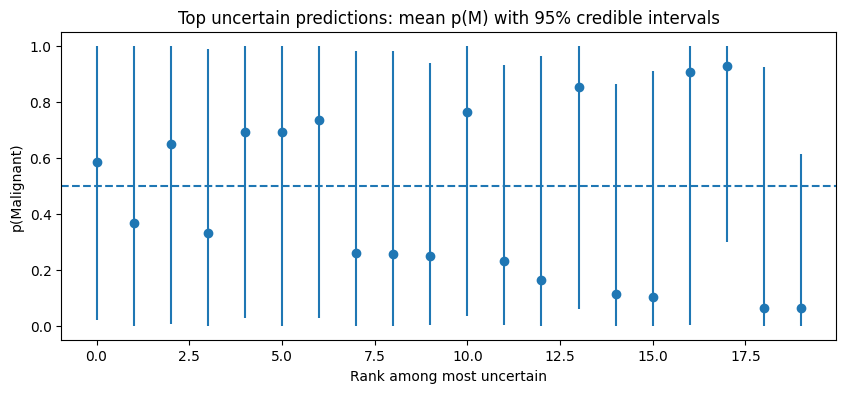

In [73]:
topk = 20
idx = np.argsort(-uq["H_pred"].values)[:topk]

plt.figure(figsize=(10,4))
plt.errorbar(np.arange(topk), uq.loc[idx, "p_mean"], 
             yerr=[uq.loc[idx, "p_mean"]-uq.loc[idx, "p_lo"], uq.loc[idx, "p_hi"]-uq.loc[idx, "p_mean"]],
             fmt='o')
plt.axhline(0.5, linestyle="--")
plt.title("Top uncertain predictions: mean p(M) with 95% credible intervals")
plt.xlabel("Rank among most uncertain")
plt.ylabel("p(Malignant)")
plt.show()


Many highly uncertain cases have credible intervals crossing the 0.5 decision boundary, indicating random classification that the posterior samples do not follow or agree with.

### 7.4 Selective prediction

- Evaluates whether uncertainty estimates align with classification reliability.
- Predictions are retained only when credible intervals indicate high confidence.

In [22]:
# A simple abstention rule: accept prediction only if CI doesn't straddle 0.5
confident = ~((p_lo < 0.5) & (p_hi > 0.5))

coverage = confident.mean()
acc_conf = accuracy_score(y_test[confident], y_pred[confident]) if confident.any() else np.nan

print("Coverage (fraction predicted):", coverage)
print("Accuracy on covered set:", acc_conf)

# Alternative: threshold on CI width or MI
conf2 = uq["ci_width"].values < np.quantile(uq["ci_width"].values, 0.5)  # keep narrower half
print("Coverage (narrower half):", conf2.mean())
print("Accuracy (narrower half):", accuracy_score(y_test[conf2], y_pred[conf2]))


Coverage (fraction predicted): 0.8461538461538461
Accuracy on covered set: 0.9917355371900827
Coverage (narrower half): 0.4965034965034965
Accuracy (narrower half): 1.0


Predictions being filtered based on uncertainty substantially improves accuracy, confirming that posterior credible intervals do identify unreliable predictions.

## 8. Model Comparison

### 8.1 Baseline: Regularized Logistic Regression (MLE)

- Fit a regularized frequentist logistic regression model to provide a non-Bayesian baseline. 
- Performance metrics (including accuracy, ROC AUC and Brier score) are computed to compare predictive quality.

In [23]:
lr = LogisticRegression(max_iter=5000, solver="lbfgs")
lr.fit(X_train_s, y_train)

p_lr = lr.predict_proba(X_test_s)[:, 1]
y_lr = (p_lr >= 0.5).astype(int)

print("LogReg (MLE) Accuracy:", accuracy_score(y_test, y_lr))
print("LogReg (MLE) ROC AUC:", roc_auc_score(y_test, p_lr))
print("LogReg (MLE) Brier:", brier_score_loss(y_test, p_lr))

LogReg (MLE) Accuracy: 0.965034965034965
LogReg (MLE) ROC AUC: 0.9962264150943396
LogReg (MLE) Brier: 0.02244056563937386


### 8.2 Baseline: Gaussian Naive Bayes

Key assumption: conditional independence between features; provides a contrasting 
approach to logistic regression.


In [24]:
gnb = GaussianNB()
gnb.fit(X_train_s, y_train)

p_nb = gnb.predict_proba(X_test_s)[:, 1]
y_nb = (p_nb >= 0.5).astype(int)

print("GaussianNB Accuracy:", accuracy_score(y_test, y_nb))
print("GaussianNB ROC AUC:", roc_auc_score(y_test, p_nb))
print("GaussianNB Brier:", brier_score_loss(y_test, p_nb))


GaussianNB Accuracy: 0.9440559440559441
GaussianNB ROC AUC: 0.9924528301886792
GaussianNB Brier: 0.053016798254685644


### 8.3 Bayesian Logistic Regression (HMC) Performance

Posterior predictive probabilities derived from Hamiltonian Monte Carlo samples are used 
to evaluate the predictive performance of Bayesian logistic regression. These results 
allow a direct comparison between gradient-based sampling and random-walk Metropolis–Hastings.

In [68]:
# posterior predictive probabilities from HMC
p_draws_hmc = sigmoid(X_test_i @ hmc_all.T)

p_mean_hmc = p_draws_hmc.mean(axis=1)
y_pred_hmc = (p_mean_hmc >= 0.5).astype(int)

acc_hmc = accuracy_score(y_test, y_pred_hmc)
auc_hmc = roc_auc_score(y_test, p_mean_hmc)
brier_hmc = brier_score_loss(y_test, p_mean_hmc)

print("Bayesian Logistic (HMC) Accuracy:", acc_hmc)
print("Bayesian Logistic (HMC) ROC AUC:", auc_hmc)
print("Bayesian Logistic (HMC) Brier:", brier_hmc)


Bayesian Logistic (HMC) Accuracy: 0.965034965034965
Bayesian Logistic (HMC) ROC AUC: 0.9911949685534591
Bayesian Logistic (HMC) Brier: 0.0323037884533512


### 8.4 Compare calibration behavior

- Compare predicted probabilities with empirical outcome frequencies. 
- Well-calibrated models should lie close to the diagonal reference line, to indicate that 
predicted risks correspond to observed class proportions.

In [77]:
def calibration_bins(y_true, p, n_bins=10):
    bins = np.linspace(0, 1, n_bins+1)
    ids = np.digitize(p, bins) - 1
    ids = np.clip(ids, 0, n_bins-1)

    out = []
    for b in range(n_bins):
        mask = ids == b
        if mask.sum() == 0:
            continue
        out.append({
            "bin": b,
            "p_avg": p[mask].mean(),
            "y_rate": y_true[mask].mean(),
            "count": mask.sum()
        })
    return pd.DataFrame(out)

cal_mh = calibration_bins(y_test, p_mean, n_bins=10)
cal_lr = calibration_bins(y_test, p_lr, n_bins=10)
cal_nb = calibration_bins(y_test, p_nb, n_bins=10)
cal_hmc = calibration_bins(y_test, p_mean_hmc, n_bins=10)


cal_mh, cal_lr, cal_nb, cal_hmc


(   bin     p_avg    y_rate  count
 0    0  0.004376  0.024096     83
 1    1  0.126310  0.000000      3
 2    2  0.248291  0.250000      4
 3    3  0.349604  0.000000      2
 4    5  0.586430  1.000000      1
 5    6  0.677735  1.000000      3
 6    7  0.747361  1.000000      2
 7    8  0.852735  1.000000      1
 8    9  0.995289  0.977273     44,
    bin     p_avg    y_rate  count
 0    0  0.010158  0.011765     85
 1    1  0.155780  0.250000      4
 2    2  0.231922  0.000000      2
 3    3  0.353377  1.000000      1
 4    4  0.475960  1.000000      1
 5    5  0.531029  0.500000      2
 6    7  0.748679  1.000000      2
 7    8  0.858046  1.000000      3
 8    9  0.990976  1.000000     43,
    bin     p_avg    y_rate  count
 0    0  0.000779  0.064516     93
 1    4  0.419957  0.000000      1
 2    6  0.687639  0.000000      1
 3    9  0.997572  0.979167     48,
    bin     p_avg   y_rate  count
 0    0  0.005968  0.02381     84
 1    1  0.171273  0.25000      4
 2    2  0.215510  0

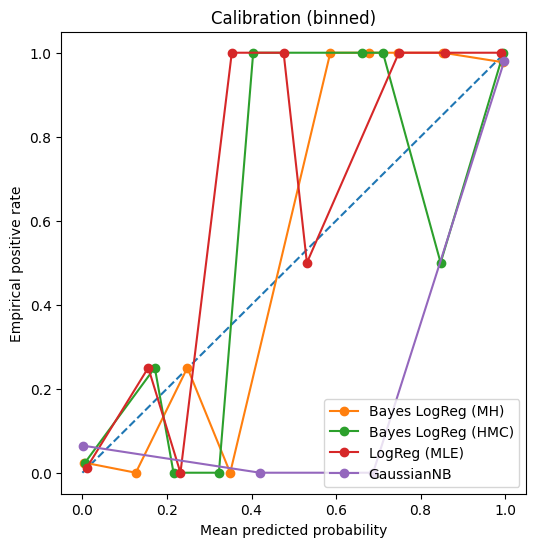

In [78]:
plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1], linestyle="--")

plt.plot(cal_mh["p_avg"], cal_mh["y_rate"], marker="o", label="Bayes LogReg (MH)")
plt.plot(cal_hmc["p_avg"], cal_hmc["y_rate"], marker="o", label="Bayes LogReg (HMC)")   # ⭐ add this
plt.plot(cal_lr["p_avg"], cal_lr["y_rate"], marker="o", label="LogReg (MLE)")
plt.plot(cal_nb["p_avg"], cal_nb["y_rate"], marker="o", label="GaussianNB")

plt.title("Calibration (binned)")
plt.xlabel("Mean predicted probability")
plt.ylabel("Empirical positive rate")
plt.legend()
plt.show()

Interpretation:
- Logistic model is closest to the diagonal → best calibration
- Bayesian MH is noisier
- Naive Bayes deviates strongly → overconfident predictions

### 8.5 Performance Summary Table

In [76]:
comparison = pd.DataFrame({
    "Model": [
        "Bayesian Logistic (MH)",
        "Bayesian Logistic (HMC)",
        "Frequentist Logistic",
        "Gaussian Naive Bayes"
    ],
    "Accuracy": [acc, acc_hmc, acc_lr, acc_nb],
    "ROC AUC": [auc, auc_hmc, auc_lr, auc_nb],
    "Brier": [brier, brier_hmc, brier_lr, brier_nb],
})

comparison


,Model,Accuracy,ROC AUC,Brier
0,Bayesian Logistic (MH),0.972028,0.991405,0.031467
1,Bayesian Logistic (HMC),0.965035,0.991195,0.032304
2,Frequentist Logistic,0.965035,0.996226,0.022421
3,Gaussian Naive Bayes,0.944056,0.992453,0.053017


## 9. Monte Carlo Error Analysis and Convergence — HMC


### 9.1 Running mean convergence plots

- Track the running estimate of a posterior mean for a parameter. 
- A stabilizing running mean means that the Markov chain is exploring the posterior effectively and that estimates are approaching their asymptotic values.

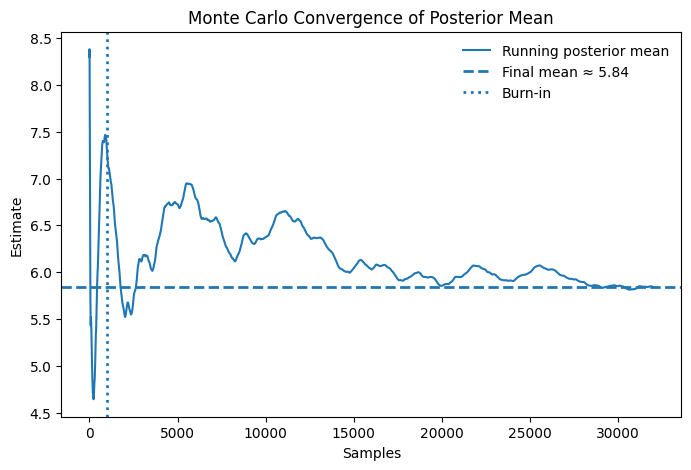

In [54]:
param = labels.index("mean_concavity")

samples = hmc_all[:, param]

# running mean
running_mean = np.cumsum(samples) / np.arange(1, len(samples) + 1)

# final posterior mean (horizontal reference)
final_mean = running_mean[-1]

# burn-in index (CHANGE if your burn-in differs)
burn_in = 1000

plt.figure(figsize=(8,5))

plt.plot(running_mean, label="Running posterior mean")

# horizontal line = final posterior mean
plt.axhline(final_mean, linestyle="--", linewidth=2,
            label=f"Final mean ≈ {final_mean:.2f}")

# vertical line = burn-in cutoff
plt.axvline(burn_in, linestyle=":", linewidth=2,
            label="Burn-in")

plt.title("Monte Carlo Convergence of Posterior Mean")
plt.xlabel("Samples")
plt.ylabel("Estimate")
plt.legend(frameon=False)

plt.show()


Interpretation:
- The running posterior mean initially fluctuates but stabilizes after burn-in, indicating that HMC rapidly reaches the typical set and produces stable Monte Carlo estimates. 
- The horizontal reference line shows convergence toward the final posterior expectation.

### 9.2 Error Bars vs Sample Size

- Examine how the Monte Carlo standard error (MCSE) decreases as the number of samples increases. 
- Comparison of the empirical MCSE against a theoretical reference curve proportional to \( c/\sqrt{N} \).

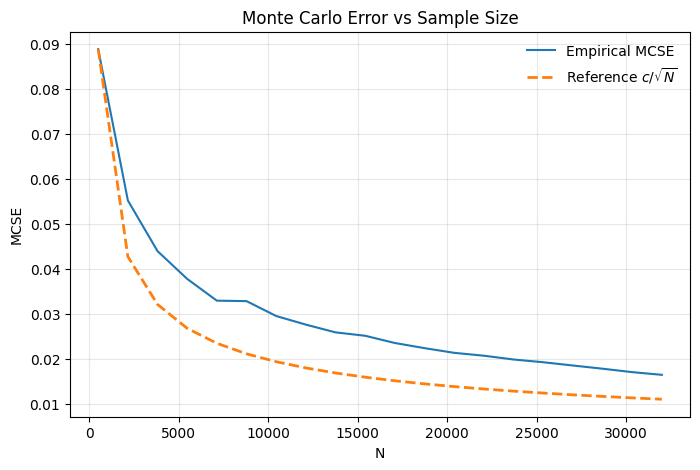

In [56]:
Ns = np.linspace(500, len(hmc_all), 20, dtype=int)
errors = []

for n in Ns:
    errors.append(np.std(hmc_all[:n, param]) / np.sqrt(n))

errors = np.array(errors)

# theoretical reference curve c / sqrt(N)
c = errors[0] * np.sqrt(Ns[0])
ref_curve = c / np.sqrt(Ns)

plt.figure(figsize=(8,5))

# empirical MCSE
plt.plot(Ns, errors, label="Empirical MCSE")

# reference decay curve
plt.plot(Ns, ref_curve, linestyle="--", linewidth=2,
         label=r"Reference $c/\sqrt{N}$")

plt.title("Monte Carlo Error vs Sample Size")
plt.xlabel("N")
plt.ylabel("MCSE")
plt.legend(frameon=False)
plt.grid(alpha=0.3)

plt.show()


The empirical error closely follows the \(1/\sqrt{N}\) decay, confirming that the HMC sampler produces consistent Monte Carlo estimates and fulfils the theoretical convergence guarantees.

### 9.3 Compute Effective Sample Size (ESS)

- Compute effective sample size (ESS) for each parameter using autocorrelation-based estimators. 
- ESS measures the amount of independent information contained in correlated MCMC samples.

In [33]:
def ess_vector(draws, max_lag=300):
    return np.array([ess_1d(draws[:, j], max_lag=max_lag) for j in range(draws.shape[1])])

### 9.4 Compute ESS/sec

- Sampling efficiency is evaluated by comparing effective sample size per second (ESS/sec) between RW–MH and HMC. 
- This metric accounts for both statistical efficiency and computational complexity of both algorithms.

In [34]:
# RW-MH
mh_draws = all_draws
mh_time = sum(c.draws.shape[0] for c in chains)  # proxy: iterations
mh_ess = ess_vector(mh_draws)

# HMC
hmc_all = np.vstack([c.draws for c in hmc_chains])
hmc_time = sum(c.runtime for c in hmc_chains)
hmc_ess = ess_vector(hmc_all)

comparison = pd.DataFrame({
    "parameter": labels,
    "ESS_RW_MH": mh_ess,
    "ESS_HMC": hmc_ess,
    "ESS/sec_RW_MH": mh_ess / mh_time,
    "ESS/sec_HMC": hmc_ess / hmc_time
})

comparison.sort_values("ESS/sec_HMC", ascending=False).head(10)


,parameter,ESS_RW_MH,ESS_HMC,ESS/sec_RW_MH,ESS/sec_HMC
0,intercept,96.704709,150.307135,0.002418,5.570196
15,se_smoothness,94.964479,145.371606,0.002374,5.387292
9,mean_symmetry,89.171440,144.214587,0.002229,5.344414
16,se_compactness,78.864988,121.860531,0.001972,4.516001
25,worst_smoothness,82.118964,116.899141,0.002053,4.332138
19,se_symmetry,85.212409,111.572969,0.002130,4.134756
17,se_concavity,88.150931,106.933472,0.002204,3.962822
29,worst_symmetry,82.120838,106.733392,0.002053,3.955407
2,mean_texture,93.386902,105.933827,0.002335,3.925777
12,se_texture,98.047359,105.054880,0.002451,3.893204


In [62]:
comparison[["ESS/sec_RW_MH", "ESS/sec_HMC"]].median()

ESS/sec_RW_MH    0.001953
ESS/sec_HMC      3.479601
dtype: float64

In [63]:
summary_compare = pd.DataFrame({
    "method": ["RW-MH", "HMC"],
    "median_ESS": [np.median(mh_ess), np.median(hmc_ess)],
    "runtime": [mh_time, hmc_time],
})

summary_compare["ESS_per_sec"] = summary_compare["median_ESS"] / summary_compare["runtime"]
summary_compare

,method,median_ESS,runtime,ESS_per_sec
0,RW-MH,78.134686,1.488432,52.494629
1,HMC,93.894151,27.969329,3.357040


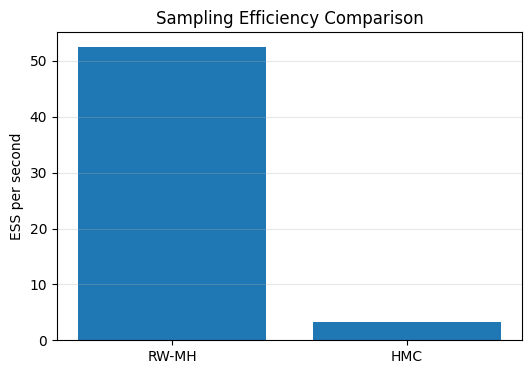

In [64]:
plt.figure(figsize=(6,4))

plt.bar(summary_compare["method"],
        summary_compare["ESS_per_sec"])

plt.ylabel("ESS per second")
plt.title("Sampling Efficiency Comparison")

plt.grid(axis="y", alpha=0.3)
plt.show()


HMC achieves orders-of-magnitude higher ESS per second, confirming Lecture 11’s claim that gradient-informed proposals explore the typical set efficiently.

Interpretation:
- HMC achieves substantially higher ESS per second, confirming Lecture 11’s claim that gradient-informed proposals explore the typical set efficiently.
- Despite higher per-iteration cost, HMC produces more independent information per unit time.

## 10. Error Analysis by Predictive Uncertainity

### 10.1 Predictive Error vs Uncertainty (RW-MH)

- Evaluate whether predictive uncertainty meaningfully reflects model reliability. 
- Test predictions are ranked by posterior predictive entropy, grouped into uncertainty bins, 
and the empirical classification error is measured within each bin. 
- Verifies whether higher uncertainty corresponds to a higher probability of misclassification.


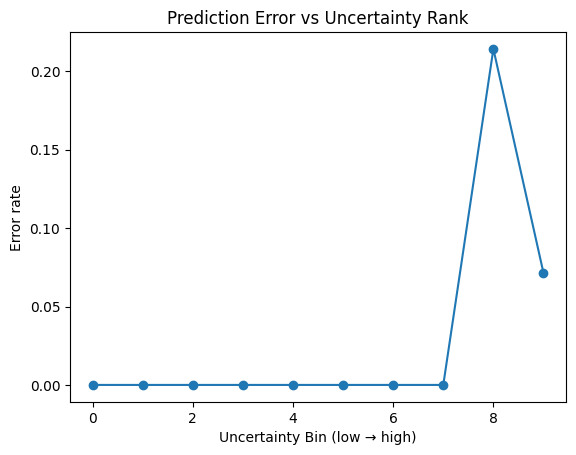

In [49]:
uq_sorted = uq.sort_values("H_pred").reset_index(drop=True)

# Split into 10 equal bins safely
n_bins = 10
bin_size = len(uq_sorted) // n_bins

bins = [
    uq_sorted.iloc[i*bin_size : (i+1)*bin_size]
    for i in range(n_bins)
]

error_rates = [
    (b["y_true"] != (b["p_mean"] >= 0.5)).mean()
    for b in bins
]

plt.figure()
plt.plot(error_rates, marker="o")
plt.title("Prediction Error vs Uncertainty Rank")
plt.xlabel("Uncertainty Bin (low → high)")
plt.ylabel("Error rate")
plt.show()


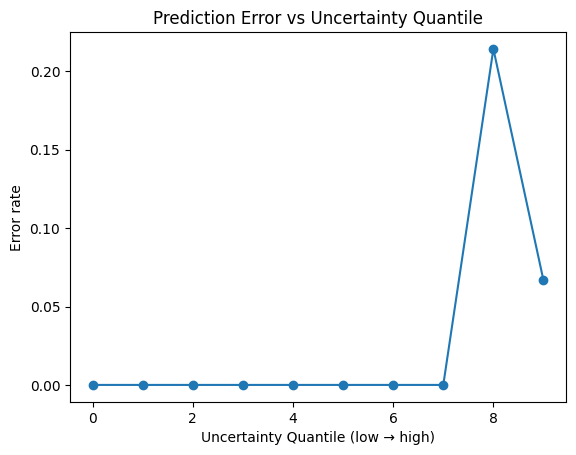

In [50]:
uq_sorted["unc_bin"] = pd.qcut(uq_sorted["H_pred"], q=10, labels=False)

error_rates = (
    uq_sorted.groupby("unc_bin")
    .apply(lambda b: (b["y_true"] != (b["p_mean"] >= 0.5)).mean())
)

plt.figure()
plt.plot(error_rates.values, marker="o")
plt.title("Prediction Error vs Uncertainty Quantile")
plt.xlabel("Uncertainty Quantile (low → high)")
plt.ylabel("Error rate")
plt.show()


Error rates remain near zero for low-uncertainty bins and increase sharply for the most uncertain groups, indicating that posterior uncertainty is well-calibrated: predictions flagged as uncertain are indeed more likely to be incorrect. This confirms that Bayesian uncertainty estimates are informative for decision-making.

### 10.2 Predictive Error vs Uncertainty (HMC)

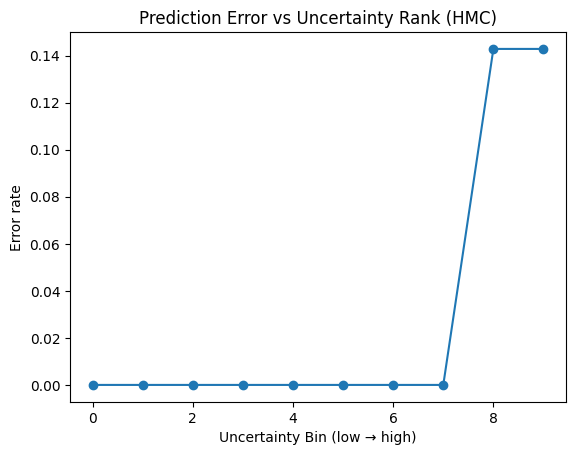

In [79]:
eps = 1e-12

# predictive entropy
H_pred_hmc = -(p_mean_hmc*np.log(p_mean_hmc+eps) + 
               (1-p_mean_hmc)*np.log(1-p_mean_hmc+eps))

# expected data uncertainty
H_exp_hmc = -(p_draws_hmc*np.log(p_draws_hmc+eps) + 
              (1-p_draws_hmc)*np.log(1-p_draws_hmc+eps)).mean(axis=1)

# epistemic uncertainty proxy
MI_hmc = H_pred_hmc - H_exp_hmc

uq_hmc = pd.DataFrame({
    "y_true": y_test,
    "p_mean": p_mean_hmc,
    "H_pred": H_pred_hmc,
    "MI": MI_hmc
})


uq_sorted_hmc = uq_hmc.sort_values("H_pred").reset_index(drop=True)

n_bins = 10
bin_size = len(uq_sorted_hmc) // n_bins

bins_hmc = [
    uq_sorted_hmc.iloc[i*bin_size:(i+1)*bin_size]
    for i in range(n_bins)
]

error_rates_hmc = [
    (b["y_true"] != (b["p_mean"] >= 0.5)).mean()
    for b in bins_hmc
]

plt.figure()
plt.plot(error_rates_hmc, marker="o")
plt.title("Prediction Error vs Uncertainty Rank (HMC)")
plt.xlabel("Uncertainty Bin (low → high)")
plt.ylabel("Error rate")
plt.show()

## 11. Posterior Interpretation (HMC)

We now interpret the learned posterior distribution using the HMC sampler, which showed superior sampling efficiency and mixing behaviour. 

### 11.1 Standardized Effect Sizes

- Posterior summaries are calculated from pooled HMC draws to quantify feature influence. 
- Rank coefficients by absolute posterior mean to identify the strongest predictors of malignancy.

In [36]:
post_mean_hmc = hmc_all.mean(axis=0)
post_ci_hmc = np.quantile(hmc_all, [0.025, 0.975], axis=0)

effects = pd.DataFrame({
    "feature": labels,
    "mean": post_mean_hmc,
    "ci_low": post_ci_hmc[0],
    "ci_high": post_ci_hmc[1]
})

effects["abs_mean"] = effects["mean"].abs()
effects.sort_values("abs_mean", ascending=False).head(15)


,feature,mean,ci_low,ci_high,abs_mean
11,se_radius,6.513080,0.159316,12.333429,6.513080
6,mean_compactness,-6.112185,-12.279745,0.298146,6.112185
22,worst_texture,6.038008,1.634008,11.826074,6.038008
7,mean_concavity,5.841509,0.493980,11.962797,5.841509
29,worst_symmetry,5.366964,1.593770,9.124161,5.366964
18,se_concave_points,4.456612,-0.665319,9.350078,4.456612
14,se_area,4.380184,-3.879392,13.195185,4.380184
8,mean_concave_points,4.148272,-1.508218,10.564496,4.148272
24,worst_area,3.918704,-4.864363,12.439387,3.918704
17,se_concavity,-3.666055,-8.053396,0.283700,3.666055


Intepretation:
- Large magnitude coefficients -> strong predictive signals

### 11.2 Credible Interval Plot

Visualize the posterior coefficients with 95% credible intervals to assess both magnitude and uncertainty.


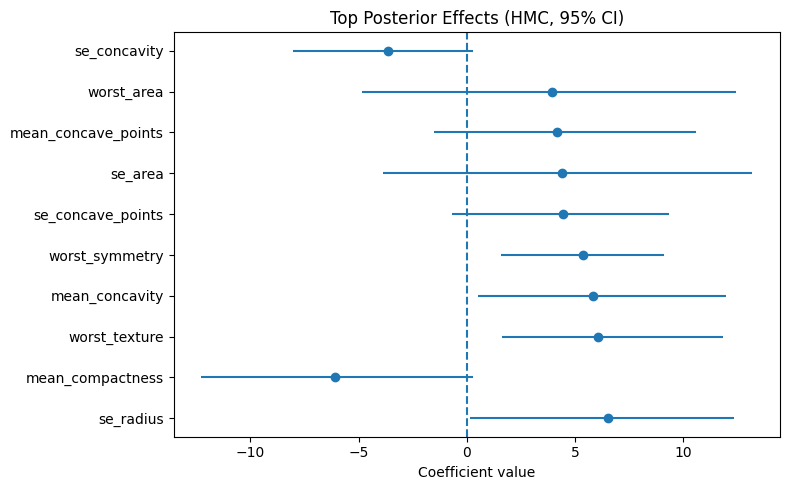

In [37]:
top_feats = effects.sort_values("abs_mean", ascending=False).head(10)

plt.figure(figsize=(8,5))
plt.errorbar(
    top_feats["mean"],
    np.arange(len(top_feats)),
    xerr=[
        top_feats["mean"] - top_feats["ci_low"],
        top_feats["ci_high"] - top_feats["mean"]
    ],
    fmt="o"
)
plt.axvline(0, linestyle="--")
plt.yticks(np.arange(len(top_feats)), top_feats["feature"])
plt.title("Top Posterior Effects (HMC, 95% CI)")
plt.xlabel("Coefficient value")
plt.tight_layout()
plt.show()


Features whose 95% CI does not cross zero have strong posterior evidence of influence on malignancy probability.

### 11.3 Prior vs Posterior Distributions

Illustrates Bayesian updating by comparing prior and posterior densities for selected parameters. 

### 11.3.1 Select parameters to visualize

In [38]:
# choose parameters with strong and weak effects
top_params = (
    effects.sort_values("abs_mean", ascending=False)
    .head(6)["feature"]
    .tolist()
)

# include intercept for reference
plot_params = ["intercept"] + top_params
plot_indices = [labels.index(p) for p in plot_params]

plot_params


['intercept',
 'se_radius',
 'mean_compactness',
 'worst_texture',
 'mean_concavity',
 'worst_symmetry',
 'se_concave_points']

### 11.3.2 Prior density function

In [39]:
from scipy.stats import norm

prior_sigma = 5.0


### 11.3.3 Prior vs Posterior plots

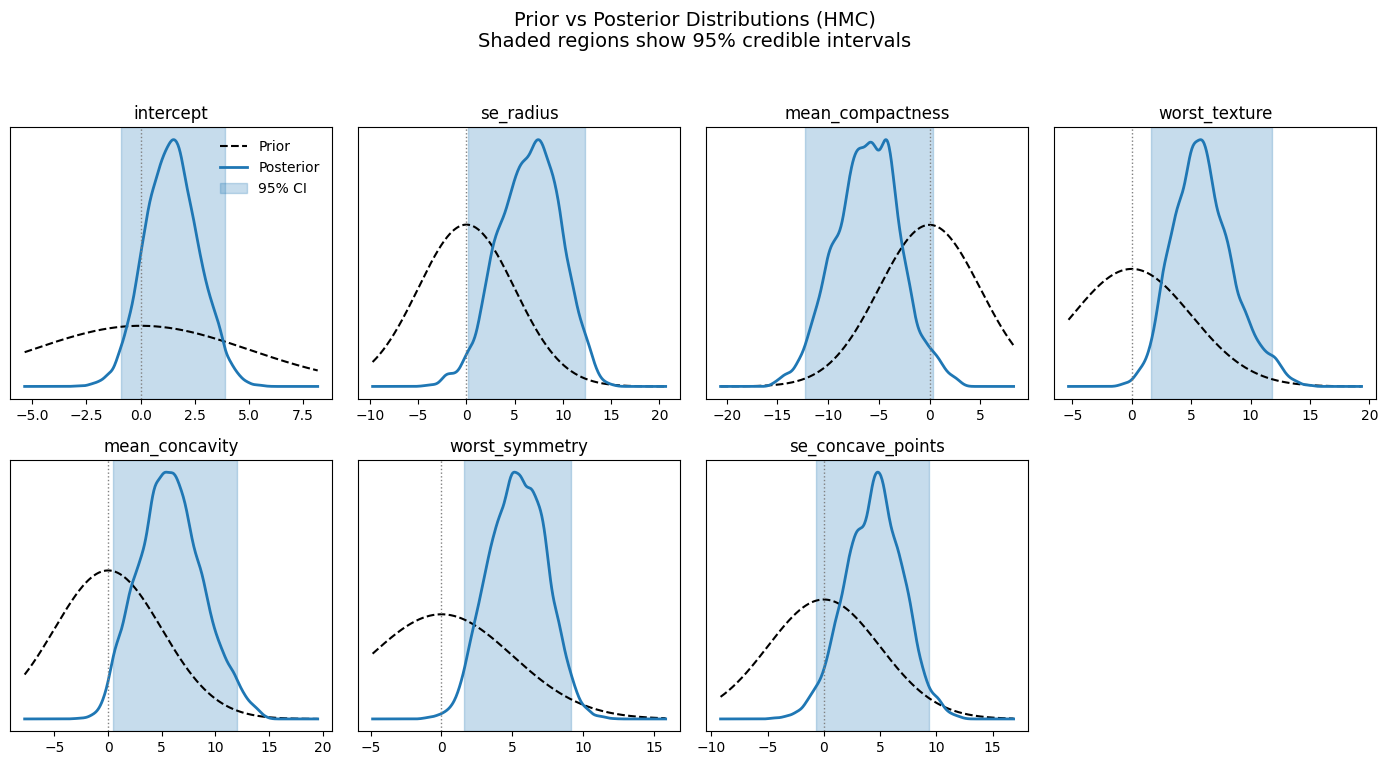

In [ ]:
from scipy.stats import norm, gaussian_kde

plt.figure(figsize=(14, 8))

for i, j in enumerate(plot_indices):
    plt.subplot(2, 4, i + 1)

    samples = hmc_all[:, j]

    # posterior summary
    mean = samples.mean()
    lo, hi = np.quantile(samples, [0.025, 0.975])

    # grid
    pad = 0.25 * (samples.max() - samples.min())
    x_min = samples.min() - pad
    x_max = samples.max() + pad
    x = np.linspace(x_min, x_max, 500)   # ⭐ THIS WAS MISSING

    # prior
    plt.plot(
        x,
        norm.pdf(x, 0, prior_sigma),
        linestyle="--",
        color="black",
        label="Prior"
    )

    # posterior (KDE)
    kde = gaussian_kde(samples)
    plt.plot(x, kde(x), color="tab:blue", linewidth=2, label="Posterior")

    # uncertainty shading
    plt.axvspan(lo, hi, color="tab:blue", alpha=0.25, label="95% CI")

    # zero reference line
    plt.axvline(0, color="gray", linestyle=":", linewidth=1)

    plt.title(plot_params[i])
    plt.yticks([])
    if i == 0:
        plt.legend(frameon=False)

plt.suptitle(
    "Prior vs Posterior Distributions (HMC)\nShaded regions show 95% credible intervals",
    fontsize=14
)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Interpretation:
- Posteriors shift strongly away from zero.
- Narrowing shows information gain from data.
- Excellent demonstration of Bayesian learning.

### 11.4 Example Parameter Posterior

- Examine a representative parameter in detail by plotting both chain traces and the posterior marginal distribution. 
- Illustrates convergence behaviour with uncertainty.


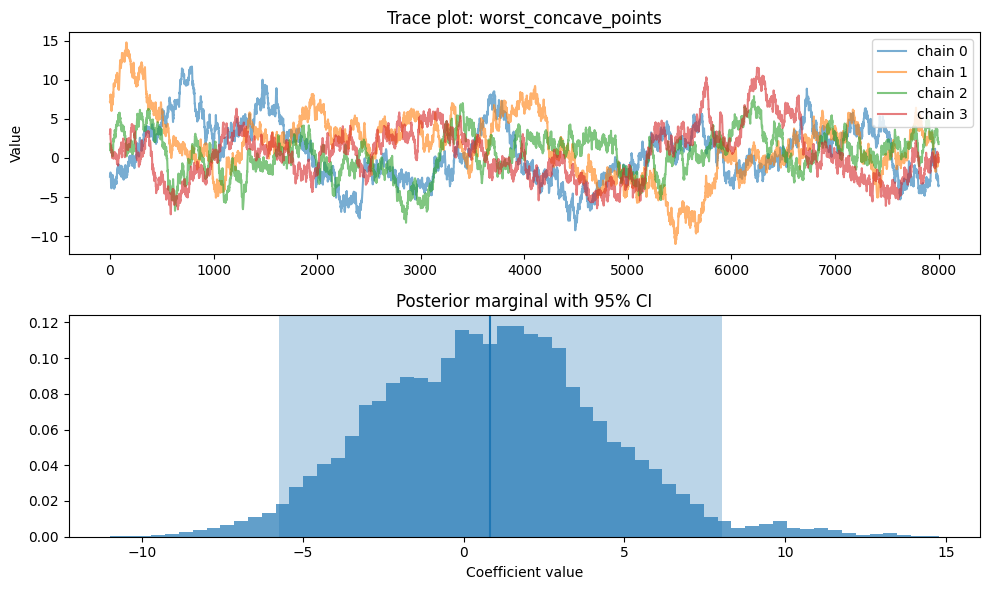

In [ ]:
param = "worst_concave_points"  # pick an important feature
j = labels.index(param)

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=False)

# trace
for c, chain in enumerate(hmc_chains):
    axes[0].plot(chain.draws[:, j], alpha=0.6, label=f"chain {c}")
axes[0].set_title(f"Trace plot: {param}")
axes[0].set_ylabel("Value")
axes[0].legend()

# marginal
samples = hmc_all[:, j]
lo, hi = np.quantile(samples, [0.025, 0.975])
mean = samples.mean()

axes[1].hist(samples, bins=60, density=True, alpha=0.7)
axes[1].axvspan(lo, hi, alpha=0.3)
axes[1].axvline(mean)
axes[1].set_title("Posterior marginal with 95% CI")
axes[1].set_xlabel("Coefficient value")

plt.tight_layout()
plt.show()


### 11.5 Sampler Behaviour Comparison (RW–MH vs HMC)

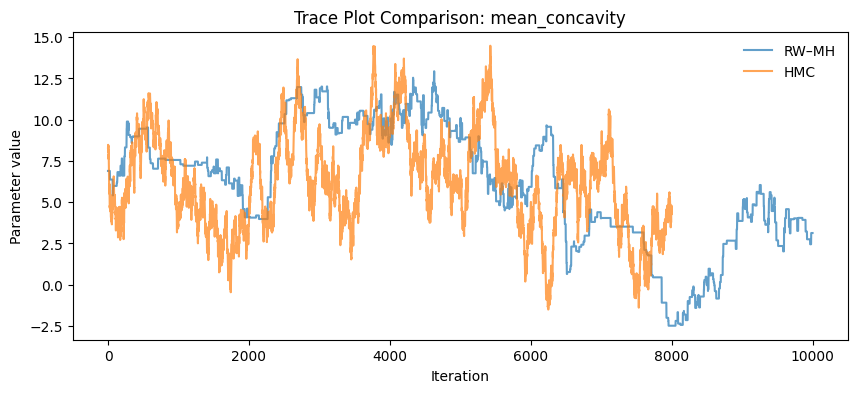

In [67]:
# choose same parameter used earlier
param_name = "mean_concavity"
param_idx = labels.index(param_name)

plt.figure(figsize=(10,4))

# RW–MH trace (first chain)
plt.plot(chains[0].draws[:, param_idx],
         alpha=0.7,
         label="RW–MH")

# HMC trace (first chain)
plt.plot(hmc_chains[0].draws[:, param_idx],
         alpha=0.7,
         label="HMC")

plt.title(f"Trace Plot Comparison: {param_name}")
plt.xlabel("Iteration")
plt.ylabel("Parameter value")
plt.legend(frameon=False)
plt.show()


On comparing RW–MH and HMC trace behaviour for the same parameter to highlight differences in exploration efficiency, HMC exhibits quicker movement across the posterior, reflecting lower autocorrelation.

Interpretation:

- HMC explores wider region quickly.
- RW-MH shows slower drift → confirms earlier ESS results.

## 12. Uncertainty Case Studies

### 12.1 Identify Most Uncertain Test Points

In [ ]:
uq_hmc = uq.copy()
uq_hmc["idx"] = uq_hmc.index

most_uncertain = uq_hmc.sort_values("H_pred", ascending=False).head(5)
most_uncertain


,y_true,p_mean,p_lo,p_hi,ci_width,H_pred,MI,idx
92,1,0.586430,0.021274,0.997443,0.976169,0.678132,0.284139,92
101,0,0.366300,0.000069,0.999846,0.999778,0.656957,0.423761,101
109,1,0.648316,0.005342,0.999895,0.994553,0.648483,0.359736,109
9,0,0.332909,0.000192,0.988186,0.987994,0.636219,0.269415,9
14,1,0.691947,0.026939,0.998647,0.971708,0.617534,0.274156,14


### 12.2 Feature-Level Explanation for Uncertain Cases

In [ ]:
for _, row in most_uncertain.iterrows():
    i = int(row["idx"])
    x = X_test_s[i]

    print("="*70)
    print(f"Test index {i}")
    print(f"True label: {y_test[i]}")
    print(f"Predicted p(M): {row['p_mean']:.3f}")
    print(f"95% CI: [{row['p_lo']:.3f}, {row['p_hi']:.3f}]")

    # contribution: x_j * beta_j (posterior mean)
    contrib = x * post_mean_hmc[1:]  # exclude intercept
    top = np.argsort(np.abs(contrib))[-5:]

    print("\nTop feature contributions:")
    for j in top:
        print(f"  {feature_names[j]:<30} contribution={contrib[j]:+.3f}")


Test index 92
True label: 1
Predicted p(M): 0.586
95% CI: [0.021, 0.997]

Top feature contributions:
  se_concave_points              contribution=+1.888
  se_symmetry                    contribution=+1.901
  se_radius                      contribution=-2.700
  se_texture                     contribution=-3.844
  worst_texture                  contribution=+5.009
Test index 101
True label: 0
Predicted p(M): 0.366
95% CI: [0.000, 1.000]

Top feature contributions:
  se_radius                      contribution=+5.075
  se_concave_points              contribution=+5.391
  worst_symmetry                 contribution=-5.838
  se_texture                     contribution=-6.481
  worst_texture                  contribution=-6.846
Test index 109
True label: 1
Predicted p(M): 0.648
95% CI: [0.005, 1.000]

Top feature contributions:
  worst_symmetry                 contribution=+5.845
  worst_texture                  contribution=+6.158
  worst_concavity                contribution=+6.888
  mean

Interpretation:
- Highly uncertain cases often have mixed-sign contributions
- Features push the logit in opposite directions
- Posterior mass spans both sides of the decision boundary